# <center>__Assignment 7__</center>

In [200]:
"""import necessary packages"""

import re
import random
import numpy as np
import pandas as pd
import missingno as msngo
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, LabelEncoder,OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as ch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

## *Data Cleaning*

### Objectives
- Get column names from metadata file (census_income_metadata.txt) and apply to census data
- Inspect the data
    - Inspect text data and clean/normalize where applicable
    - Determine unique values (levels) for categorical data
- Handle missing data appropriately
- Ensure proper datatype for each feature

In [201]:
"""read in the data"""

census_income_train = pd.read_csv('census_income_train.csv', header=None)
census_income_test = pd.read_csv('census_income_test.csv', header=None)

In [202]:
"""create a dictionary to store feature names and associated metadata"""

metadata = open('census_income_metadata.txt')
metadata = metadata.readlines()[142:184]
metadata_dict = {}
for line in metadata:
    key = re.search(r'.*(?=:)', line).group().replace(" ", '_')
    key = re.sub(f'[^\w\d_]', '', key)
    value = re.search(r'(?<=:).*', line).group()
    value = re.sub(r'[\n\.]', '', value)
    value = value.strip()
    value = [val.strip() for val in value.split(',')]
    metadata_dict[key] = value
metadata_dict['outcome'] = ['- 50000', '50000+']

In [203]:
"""
get column names from metadata dict and apply to train and test data
drop instance weight feature form training and test sets
colnames list will be re-used durig data cleaning process, remove instance_weight from list
"""

colnames = list(metadata_dict.keys())
colnames.remove('_instance_weight')
census_income_train.columns = colnames
census_income_test.columns = colnames
census_income_train.drop(columns=['instance_weight'], inplace=True)
census_income_test.drop(columns=['instance_weight'], inplace=True)
colnames.remove('instance_weight')

Clean Text Data

In [204]:
"""
check dtype to identify columns containing text data
remove . in target, strip whitespace
"""
for col in colnames:
    if census_income_train[col].dtype == 'object':
        census_income_train[col] = census_income_train[col].str.replace('.', '', regex=False)
        census_income_train[col] = census_income_train[col].str.strip()
    if census_income_test[col].dtype == 'object':
        census_income_test[col] = census_income_test[col].str.replace('.', '', regex=False)
        census_income_test[col] = census_income_test[col].str.strip()

In [205]:
"""
create list of proper data types for each feature as specified in census_income_metadata.txt
"""

continuous_features = ['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
                       'dividends_from_stocks', 'num_persons_worked_for_employer',
                       'weeks_worked_in_year']
nominal_features = [feature for feature in colnames if feature not in continuous_features]

Check Unique Values in Data

In [206]:
"""
instantiate dictionaries to store problem values idnetified in train and test sets
problem values will be determined by comparing unique values in the data to known set of unique values specified
in census_income_metadata.txt
"""
# create dictionaries
train_problem_values_dict = {}
test_problem_values_dict = {}
# get unique values from each column in train and test sets, compute set difference between actual and expected unique values
for col in nominal_features:
    unique_vals_train = set([str(val) for val in census_income_train[col].unique()])
    unique_vals_test = set([str(val) for val in census_income_test[col].unique()])
    unique_vals_metadata = set(metadata_dict[col])
    train_problem_values_dict[col] = list(unique_vals_train - unique_vals_metadata)
    test_problem_values_dict[col] = list(unique_vals_test - unique_vals_metadata)

In [207]:
"""print problem values idntified in training set"""

print(train_problem_values_dict)

{'class_of_worker': [], 'detailed_industry_recode': [], 'detailed_occupation_recode': [], 'education': [], 'enroll_in_edu_inst_last_wk': [], 'marital_stat': [], 'major_industry_code': [], 'major_occupation_code': [], 'race': [], 'hispanic_origin': [], 'sex': [], 'member_of_a_labor_union': [], 'reason_for_unemployment': [], 'full_or_part_time_employment_stat': [], 'tax_filer_stat': [], 'region_of_previous_residence': [], 'state_of_previous_residence': ['?'], 'detailed_household_and_family_stat': [], 'detailed_household_summary_in_household': [], 'migration_codechange_in_msa': ['?'], 'migration_codechange_in_reg': ['?'], 'migration_codemove_within_reg': ['?'], 'live_in_this_house_1_year_ago': [], 'migration_prev_res_in_sunbelt': ['?'], 'family_members_under_18': [], 'country_of_birth_father': ['?'], 'country_of_birth_mother': ['?'], 'country_of_birth_self': ['?'], 'citizenship': [], 'own_business_or_self_employed': [], 'fill_inc_questionnaire_for_veterans_admin': [], 'veterans_benefits':

In [208]:
"""print problem values identified in the test set"""

print(test_problem_values_dict)

{'class_of_worker': [], 'detailed_industry_recode': [], 'detailed_occupation_recode': [], 'education': [], 'enroll_in_edu_inst_last_wk': [], 'marital_stat': [], 'major_industry_code': [], 'major_occupation_code': [], 'race': [], 'hispanic_origin': [], 'sex': [], 'member_of_a_labor_union': [], 'reason_for_unemployment': [], 'full_or_part_time_employment_stat': [], 'tax_filer_stat': [], 'region_of_previous_residence': [], 'state_of_previous_residence': ['?'], 'detailed_household_and_family_stat': [], 'detailed_household_summary_in_household': [], 'migration_codechange_in_msa': ['?'], 'migration_codechange_in_reg': ['?'], 'migration_codemove_within_reg': ['?'], 'live_in_this_house_1_year_ago': [], 'migration_prev_res_in_sunbelt': ['?'], 'family_members_under_18': [], 'country_of_birth_father': ['?'], 'country_of_birth_mother': ['?'], 'country_of_birth_self': ['?'], 'citizenship': [], 'own_business_or_self_employed': [], 'fill_inc_questionnaire_for_veterans_admin': [], 'veterans_benefits':

Comparison of unique values in the training and test sets to unique values in census_income_metadata.txt shows the existence of a single problem value "?." This value will be treated as missing and replaced with "None."

In [209]:
"""change records with ? to None dtype"""
census_income_train = census_income_train.applymap(lambda x : None if x == '?' else x)
census_income_test = census_income_test.applymap(lambda x : None if x == '?' else x)

In [210]:
"""verify ? has been replaced with None in train set"""

'?' in census_income_train.values

False

In [211]:
"""verify ? has been replaced with None in test set"""

'?' in census_income_test.values

False

Check Missing Values and Missingness Mechanism in Data

In [212]:
"""print count of missing continuous features in train set"""

census_income_train[continuous_features].isnull().sum()

age                                0
wage_per_hour                      0
capital_gains                      0
capital_losses                     0
dividends_from_stocks              0
num_persons_worked_for_employer    0
weeks_worked_in_year               0
dtype: int64

In [213]:
"""print count of missing continuous features in test set"""

census_income_train[continuous_features].isnull().sum()

age                                0
wage_per_hour                      0
capital_gains                      0
capital_losses                     0
dividends_from_stocks              0
num_persons_worked_for_employer    0
weeks_worked_in_year               0
dtype: int64

In [214]:
"""print count of missing nominal features in train set"""

census_income_train[nominal_features].isnull().sum()

class_of_worker                                  0
detailed_industry_recode                         0
detailed_occupation_recode                       0
education                                        0
enroll_in_edu_inst_last_wk                       0
marital_stat                                     0
major_industry_code                              0
major_occupation_code                            0
race                                             0
hispanic_origin                                  0
sex                                              0
member_of_a_labor_union                          0
reason_for_unemployment                          0
full_or_part_time_employment_stat                0
tax_filer_stat                                   0
region_of_previous_residence                     0
state_of_previous_residence                    708
detailed_household_and_family_stat               0
detailed_household_summary_in_household          0
migration_codechange_in_msa    

In [215]:
"""print count of missing nominal features in test set"""

census_income_test[nominal_features].isnull().sum()

class_of_worker                                  0
detailed_industry_recode                         0
detailed_occupation_recode                       0
education                                        0
enroll_in_edu_inst_last_wk                       0
marital_stat                                     0
major_industry_code                              0
major_occupation_code                            0
race                                             0
hispanic_origin                                  0
sex                                              0
member_of_a_labor_union                          0
reason_for_unemployment                          0
full_or_part_time_employment_stat                0
tax_filer_stat                                   0
region_of_previous_residence                     0
state_of_previous_residence                    330
detailed_household_and_family_stat               0
detailed_household_summary_in_household          0
migration_codechange_in_msa    

In [216]:
"""drop columns missing more than 30% of data from train set"""

perc = 0.70
threshold = int(perc*census_income_train.shape[0])
census_income_train.dropna(axis=1, thresh=threshold, inplace=True)
# update nominal features index to account for dropped features
nominal_features = [feature for feature in census_income_train.columns.values.tolist() if feature not in continuous_features]

In [217]:
"""drop columns missing more than 30% of data from test set"""

perc = 0.70
threshold = int(perc*census_income_test.shape[0])
census_income_test.dropna(axis=1, thresh=threshold, inplace=True)
# update nominal features index to account for dropped features
nominal_features = [feature for feature in census_income_test.columns.values.tolist() if feature not in continuous_features]

In [218]:
"""determine total percentage of records with at least one missing attribute train set"""

census_income_train.isnull().any(axis=1).mean()*100

4.491712734872672

In [219]:
"""determine total percentage of records with at least one missing attribute test set"""

census_income_test.isnull().any(axis=1).mean()*100

4.554840520438644

<AxesSubplot:>

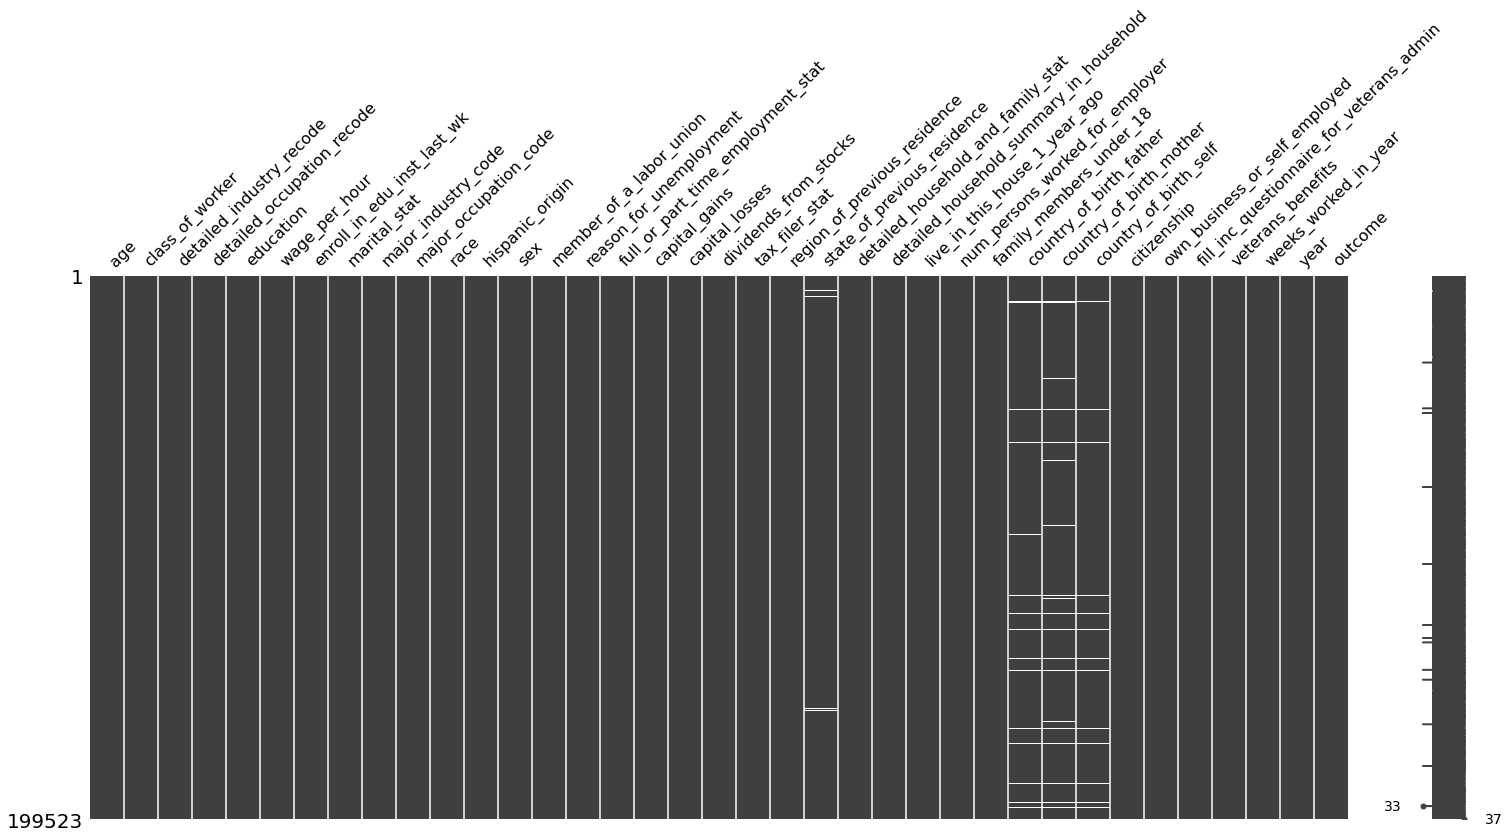

In [220]:
"""
print missing matrix for train set using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""
msngo.matrix(census_income_train)

<AxesSubplot:>

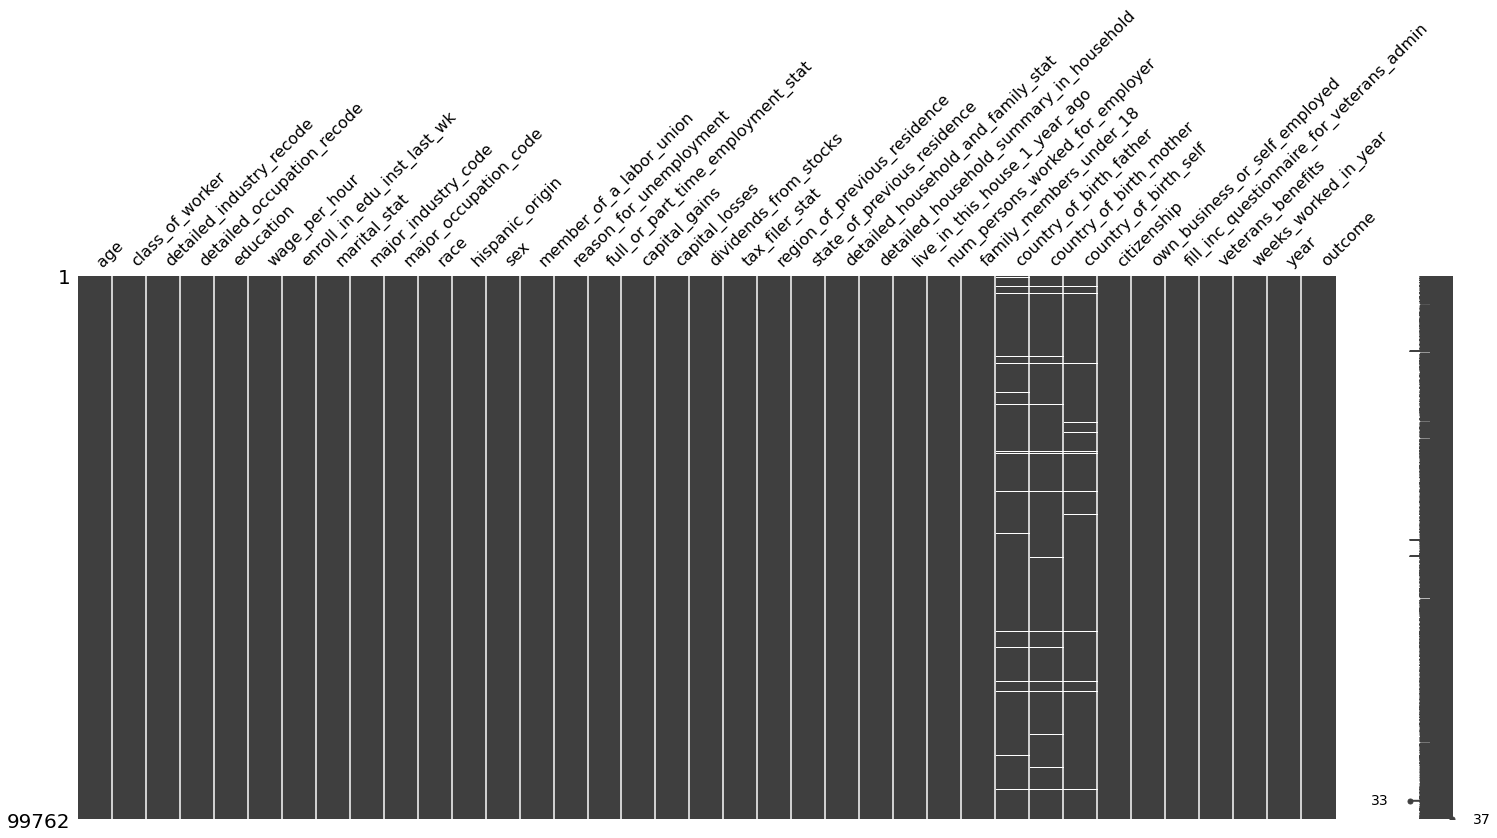

In [221]:
"""
print missing matrix for test set using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""

msngo.matrix(census_income_test)

In [222]:
"""drop records with missing attributes from train set"""

census_income_train.dropna(axis=0, inplace=True)
census_income_train.isnull().sum()

age                                          0
class_of_worker                              0
detailed_industry_recode                     0
detailed_occupation_recode                   0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_stat                                 0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_a_labor_union                      0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

In [223]:
"""drop records with missing attributes from test set"""

census_income_test.dropna(axis=0, inplace=True)
census_income_test.isnull().sum()

age                                          0
class_of_worker                              0
detailed_industry_recode                     0
detailed_occupation_recode                   0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_stat                                 0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_a_labor_union                      0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

In [224]:
"""check data types census_income_test"""

census_income_train[continuous_features].dtypes

age                                int64
wage_per_hour                      int64
capital_gains                      int64
capital_losses                     int64
dividends_from_stocks              int64
num_persons_worked_for_employer    int64
weeks_worked_in_year               int64
dtype: object

In [225]:
"""check data types census_income_test"""

census_income_test[continuous_features].dtypes

age                                int64
wage_per_hour                      int64
capital_gains                      int64
capital_losses                     int64
dividends_from_stocks              int64
num_persons_worked_for_employer    int64
weeks_worked_in_year               int64
dtype: object

In [226]:
"""convert nominal features to type category, census_income_train"""

census_income_train[nominal_features] = census_income_train[nominal_features].astype('category')
census_income_train[nominal_features].dtypes

class_of_worker                              category
detailed_industry_recode                     category
detailed_occupation_recode                   category
education                                    category
enroll_in_edu_inst_last_wk                   category
marital_stat                                 category
major_industry_code                          category
major_occupation_code                        category
race                                         category
hispanic_origin                              category
sex                                          category
member_of_a_labor_union                      category
reason_for_unemployment                      category
full_or_part_time_employment_stat            category
tax_filer_stat                               category
region_of_previous_residence                 category
state_of_previous_residence                  category
detailed_household_and_family_stat           category
detailed_household_summary_i

In [227]:
"""convert nominal features to type category, census_income_test"""

census_income_test[nominal_features] = census_income_test[nominal_features].astype('category')
census_income_test[nominal_features].dtypes

class_of_worker                              category
detailed_industry_recode                     category
detailed_occupation_recode                   category
education                                    category
enroll_in_edu_inst_last_wk                   category
marital_stat                                 category
major_industry_code                          category
major_occupation_code                        category
race                                         category
hispanic_origin                              category
sex                                          category
member_of_a_labor_union                      category
reason_for_unemployment                      category
full_or_part_time_employment_stat            category
tax_filer_stat                               category
region_of_previous_residence                 category
state_of_previous_residence                  category
detailed_household_and_family_stat           category
detailed_household_summary_i

## *Exploratory Data Analysis*

### Objectives

- Print descriptive statistics for training and test sets
- Identify extreme values (outliers) in continuous features
- Visualize distribution of continuous features
- Print frequency distribution for nominal features
- Visualize frequency distribution for select nominal features
- Visualize frequency distribution of target
    - Consider distribution of target in training and test sets

In [228]:
"""print info for clean train set"""

census_income_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190561 entries, 0 to 199521
Data columns (total 37 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   age                                        190561 non-null  int64   
 1   class_of_worker                            190561 non-null  category
 2   detailed_industry_recode                   190561 non-null  category
 3   detailed_occupation_recode                 190561 non-null  category
 4   education                                  190561 non-null  category
 5   wage_per_hour                              190561 non-null  int64   
 6   enroll_in_edu_inst_last_wk                 190561 non-null  category
 7   marital_stat                               190561 non-null  category
 8   major_industry_code                        190561 non-null  category
 9   major_occupation_code                      190561 non-null  category
 

In [229]:
"""print info for clean test set"""

census_income_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95218 entries, 0 to 99761
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   age                                        95218 non-null  int64   
 1   class_of_worker                            95218 non-null  category
 2   detailed_industry_recode                   95218 non-null  category
 3   detailed_occupation_recode                 95218 non-null  category
 4   education                                  95218 non-null  category
 5   wage_per_hour                              95218 non-null  int64   
 6   enroll_in_edu_inst_last_wk                 95218 non-null  category
 7   marital_stat                               95218 non-null  category
 8   major_industry_code                        95218 non-null  category
 9   major_occupation_code                      95218 non-null  category
 10  race      

In [230]:
"""print summary statistics for continuous features in the training set"""

census_income_train[continuous_features].agg(func=['min', 'median', 'max', 'var', 'mean', 'std',
                                                   'skew', 'kurt'])

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
median,33.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,8.000000
max,90.000000,9999.000000,9.999900e+04,4608.000000,9.999900e+04,6.000000,52.000000
var,488.466261,75518.205417,2.126503e+07,72821.844045,3.849922e+06,5.609395,596.222158
mean,34.098299,55.968866,4.232986e+02,36.905584,1.914663e+02,1.967543,23.283285
std,22.101273,274.805759,4.611403e+03,269.855228,1.962122e+03,2.368416,24.417661
skew,0.382546,8.725639,1.930975e+01,7.631722,2.817048e+01,0.742425,0.201697
kurt,-0.706727,147.591111,4.071419e+02,61.274127,1.115145e+03,-1.096691,-1.867087


In [231]:
"""print summary statistics for continuous features in the test set"""

census_income_test[continuous_features].agg(func=['min', 'median', 'max', 'mean', 'var', 'std',
                                                   'skew', 'kurt'])

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
median,33.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,10.000000
max,90.000000,9900.000000,9.999900e+04,4608.000000,9.999900e+04,6.000000,52.000000
mean,34.248419,54.808135,4.180952e+02,35.439203,1.844378e+02,1.967391,23.310488
var,489.647352,73649.924654,2.090276e+07,69560.302095,3.260230e+06,5.601098,595.171479
std,22.127977,271.385196,4.571954e+03,263.742871,1.805611e+03,2.366664,24.396137
skew,0.379706,8.794829,1.949026e+01,7.851769,2.600238e+01,0.745006,0.200046
kurt,-0.711299,151.451317,4.147171e+02,66.039433,9.923423e+02,-1.090145,-1.865806


Printing summary statistics for continuous features in the data shows the possible existnece of extreme values for features related to financials. A boxplot can be used to further confirm this assumption.

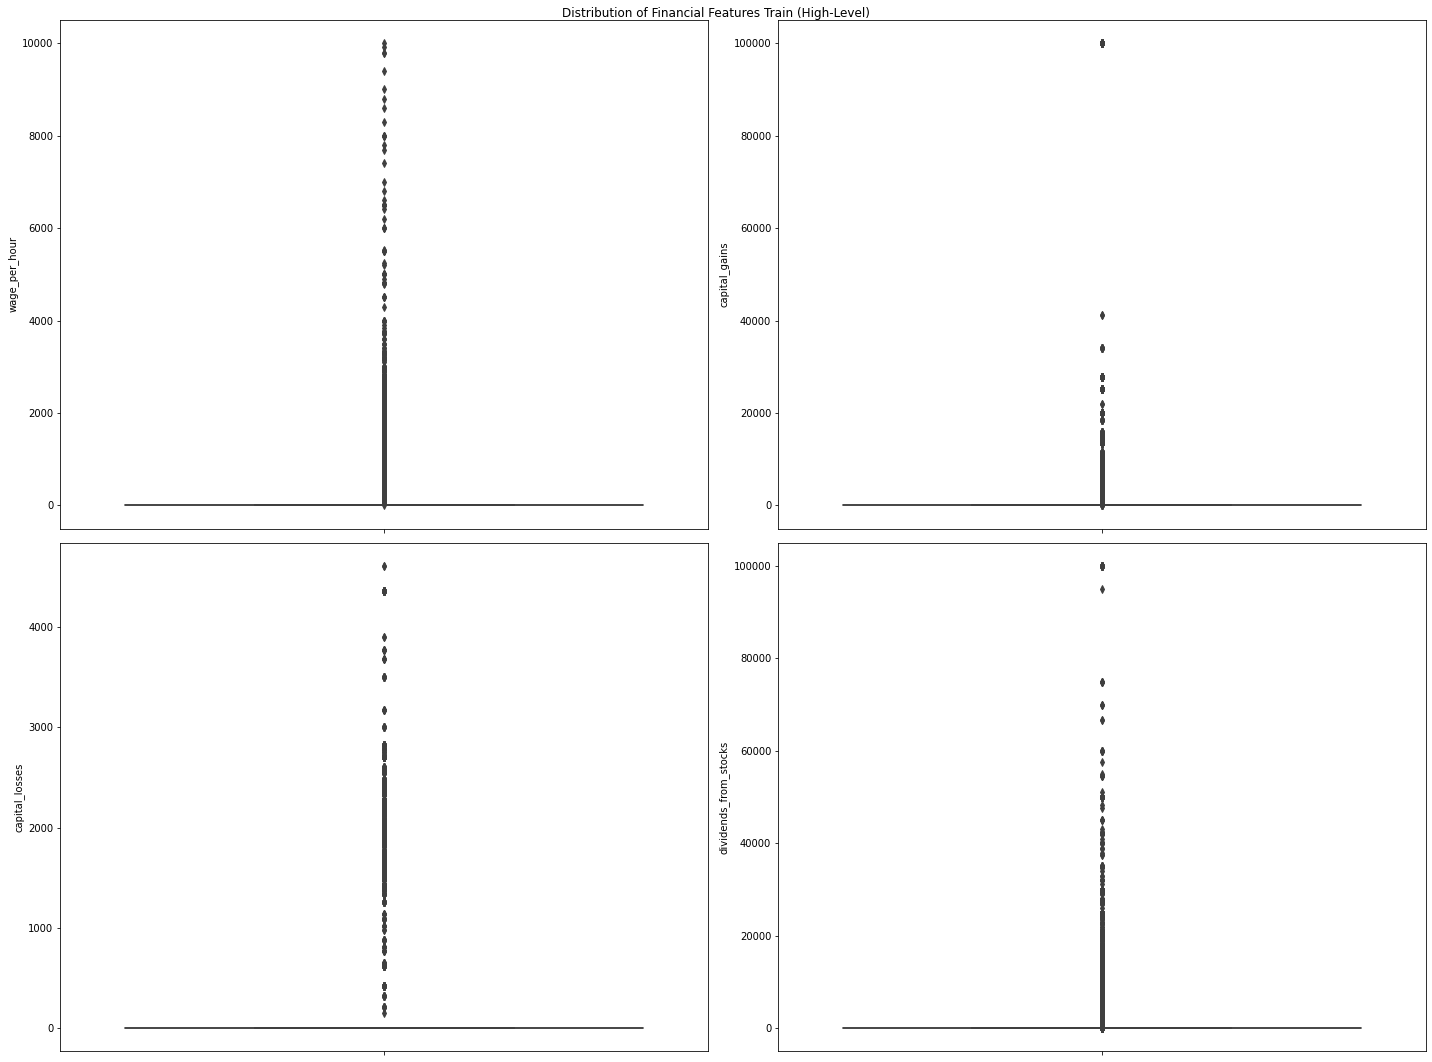

In [232]:
"""plot high-level view of distribution continuous predictors train"""

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.boxplot(data=census_income_train, y='wage_per_hour', ax=ax[0,0])
sns.boxplot(data=census_income_train, y='capital_gains', ax=ax[0, 1])
sns.boxplot(data=census_income_train, y='capital_losses', ax=ax[1, 0])
sns.boxplot(data=census_income_train, y='dividends_from_stocks', ax=ax[1, 1])
#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Financial Features Train (High-Level)')
plt.tight_layout()

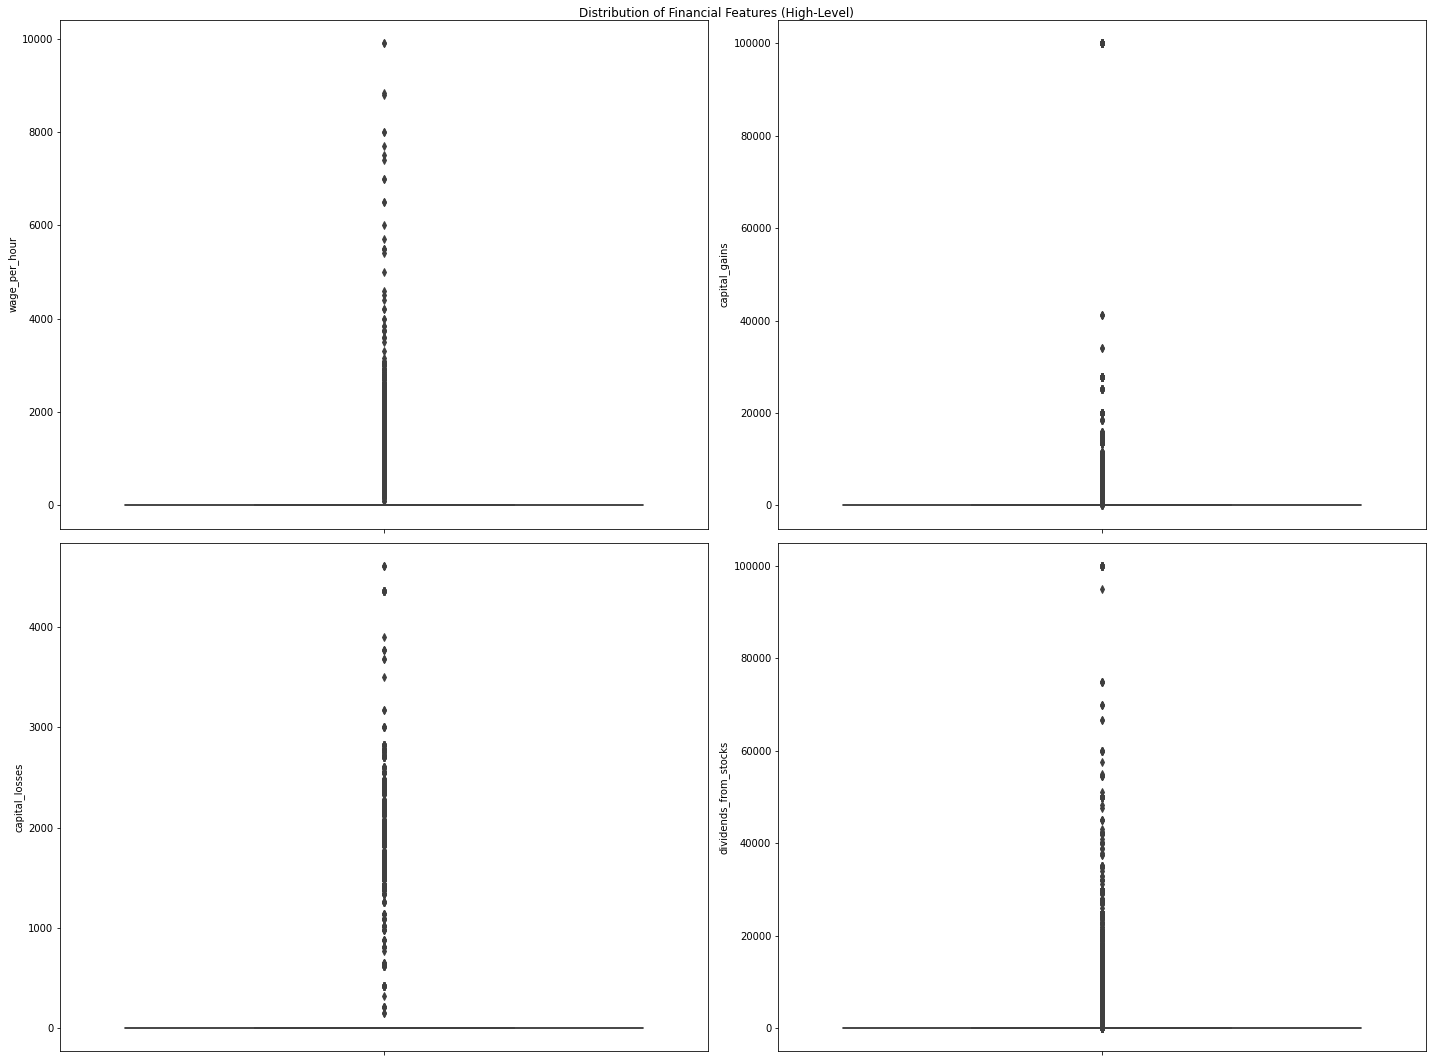

In [233]:
"""plot high-level view of distribution continuous predictors test"""

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.boxplot(data=census_income_test, y='wage_per_hour', ax=ax[0,0])
sns.boxplot(data=census_income_test, y='capital_gains', ax=ax[0, 1])
sns.boxplot(data=census_income_test, y='capital_losses', ax=ax[1, 0])
sns.boxplot(data=census_income_train, y='dividends_from_stocks', ax=ax[1, 1])
#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Financial Features (High-Level)')
plt.tight_layout()

After visualizing outliers in features related to financials it's determined that records with financial features that have a z-score with absolute value greater than 3 should be identified. If these data repressent a significant amount of records in the training and test sets then records that have a z-score with absolute value greater than three should be retained. It's also worth noting that it's not uncommon for people in the US population to have income substantially greater than their peers.

In [234]:
"""compute z-score for financial data training set and filter for z-scores with absolute value greater than 3"""

financial_features = ['wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks']
z_scores = stats.zscore(census_income_train[financial_features])
z_filter = (np.abs(z_scores > 3).any(axis=1))
census_income_train[z_filter].shape[0]/census_income_train.shape[0]*100

5.597682631808187

In [235]:
"""compute z-score for financial data test set and filter for z-scores with absolute value greater than 3"""

financial_features = ['capital_gains', 'capital_losses', 'dividends_from_stocks']
z_scores = stats.zscore(census_income_test[financial_features])
z_filter = (np.abs(z_scores > 3).any(axis=1))
census_income_test[z_filter].shape[0]/census_income_test.shape[0]*100

3.1601167846415597

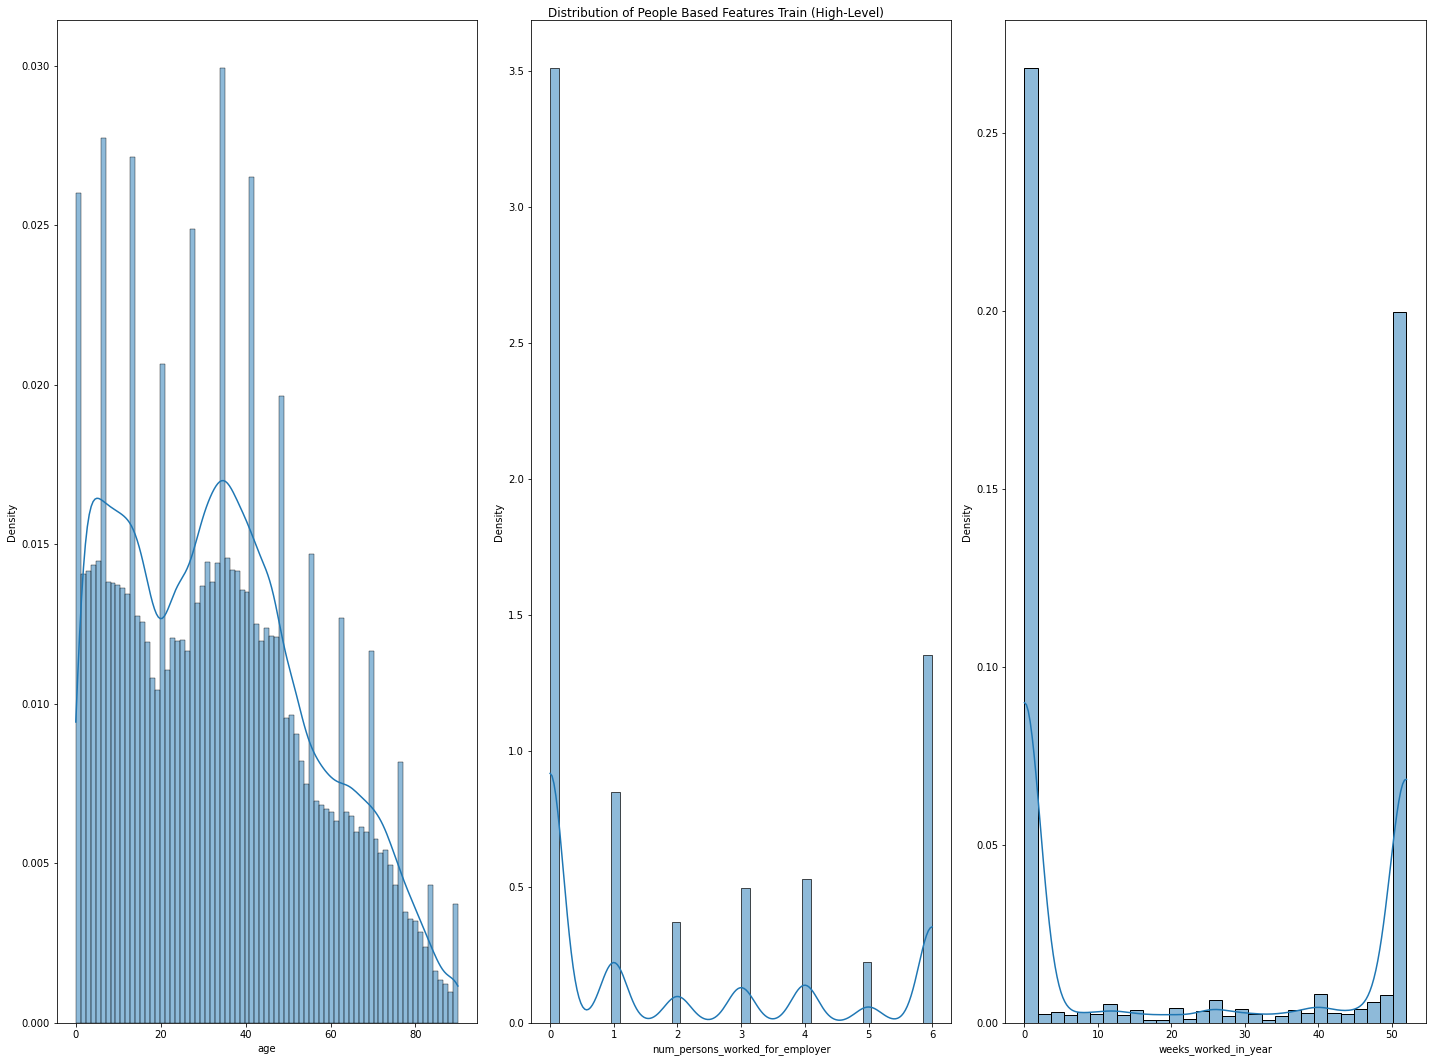

In [236]:
"""plot the distribution of people based attributes training set"""

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
sns.histplot(data=census_income_train, x='age', stat='density', kde=True, ax=ax[0])
sns.histplot(data=census_income_train, x='num_persons_worked_for_employer', stat='density', kde=True, ax=ax[1])
sns.histplot(data=census_income_train, x='weeks_worked_in_year', stat='density', kde=True, ax=ax[2])

#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of People Based Features Train (High-Level)')
plt.tight_layout()

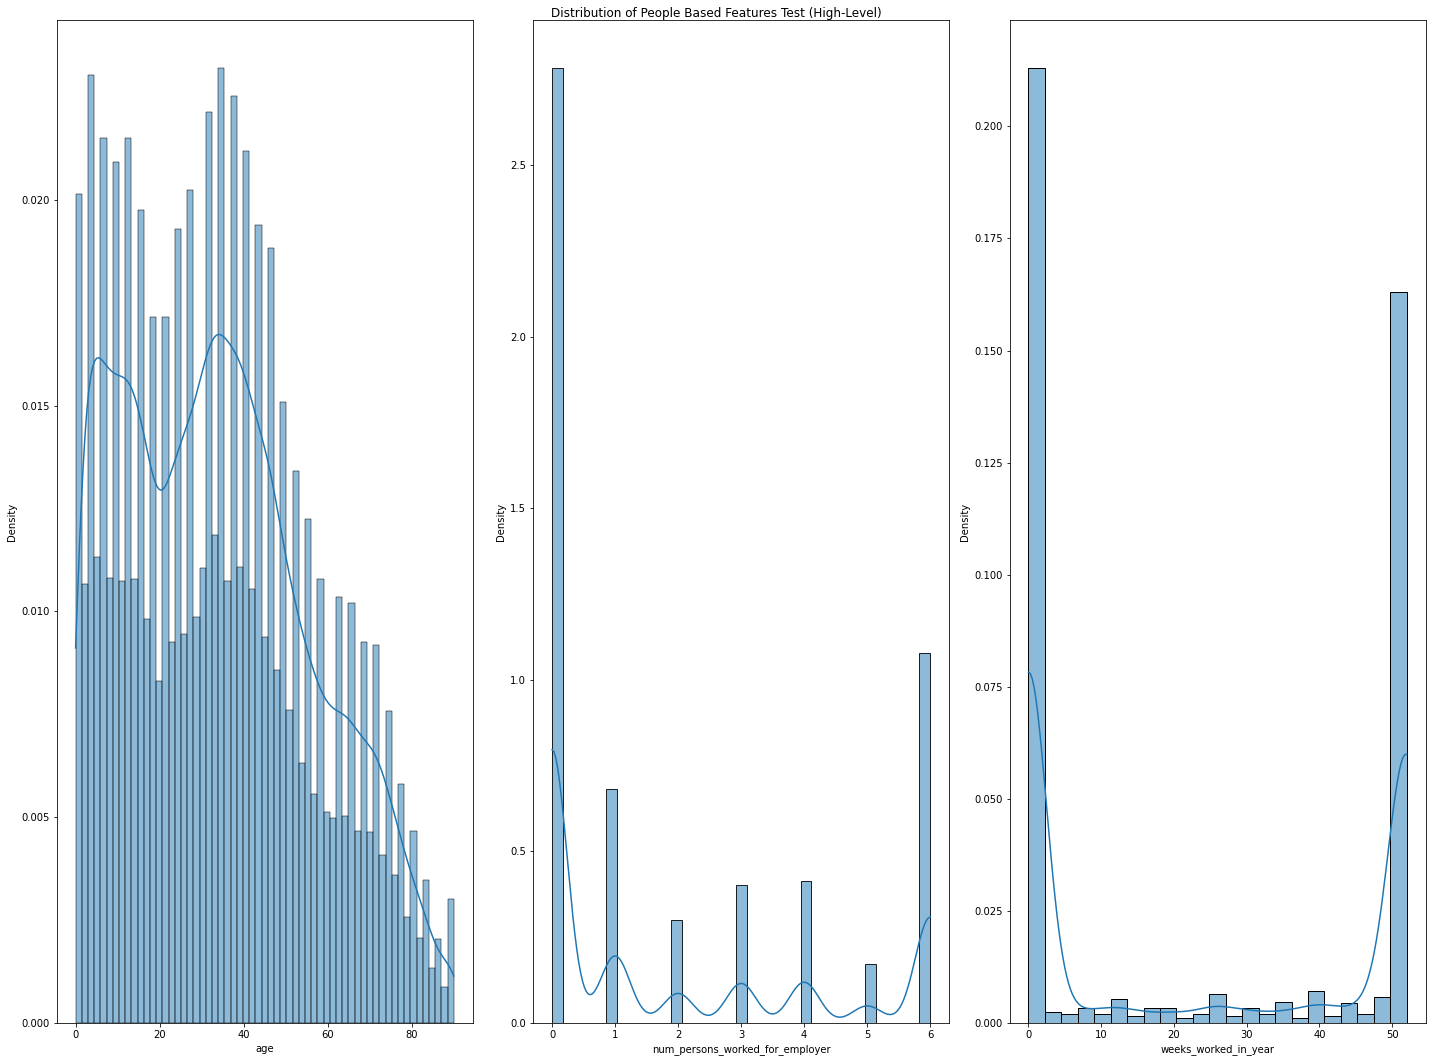

In [237]:
"""plot the distribution of people based attributes testing set"""

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
sns.histplot(data=census_income_test, x='age', stat='density', kde=True, ax=ax[0])
sns.histplot(data=census_income_test, x='num_persons_worked_for_employer', stat='density', kde=True, ax=ax[1])
sns.histplot(data=census_income_test, x='weeks_worked_in_year', stat='density', kde=True, ax=ax[2])

#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of People Based Features Test (High-Level)')
plt.tight_layout()

In [238]:
"""print frequency distribution of nominal features training set"""

for feature in nominal_features:
    print(census_income_train.value_counts(feature, normalize=True)*100)
    print()

class_of_worker
Not in universe                   50.016530
Private                           36.302811
Self-employed-not incorporated     4.218072
Local government                   3.960936
State government                   2.141047
Self-employed-incorporated         1.590567
Federal government                 1.471445
Never worked                       0.215679
Without pay                        0.082913
dtype: float64

detailed_industry_recode
0     50.232209
33     8.579405
43     4.179239
4      3.038922
42     2.356201
45     2.214514
29     2.115858
41     1.995686
37     1.988864
32     1.808345
35     1.703392
39     1.463049
34     1.379611
44     1.294074
2      1.121950
11     0.888954
50     0.863241
47     0.843824
40     0.830705
38     0.805516
24     0.755139
19     0.690068
12     0.681671
30     0.598234
31     0.596135
25     0.534212
9      0.505350
22     0.479636
36     0.472814
13     0.458646
1      0.420863
48     0.326929
27     0.318533
49     0.306464
3  

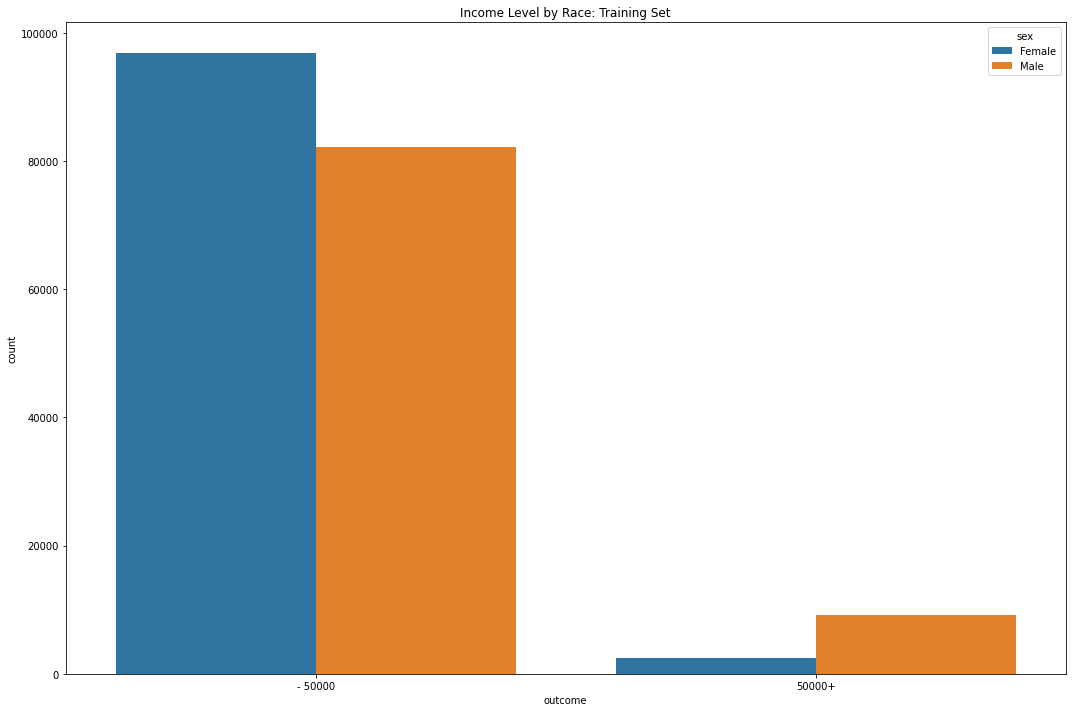

In [239]:
"""plot frequency distribution of income level by education race and sex"""

fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=census_income_train, x='outcome', hue='sex')
plt.title('Income Level by Race: Training Set')
plt.tight_layout()

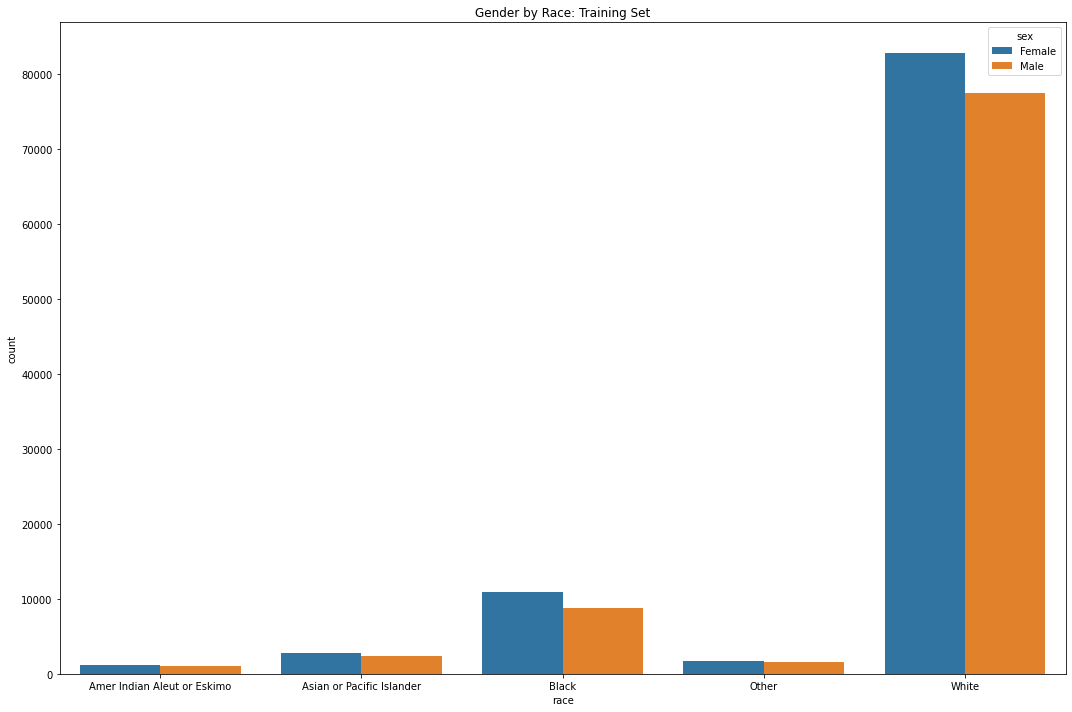

In [240]:
"""plot frequency distribution of income level by race"""

fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=census_income_train, x='race', hue='sex')
plt.title('Gender by Race: Training Set')
plt.tight_layout()

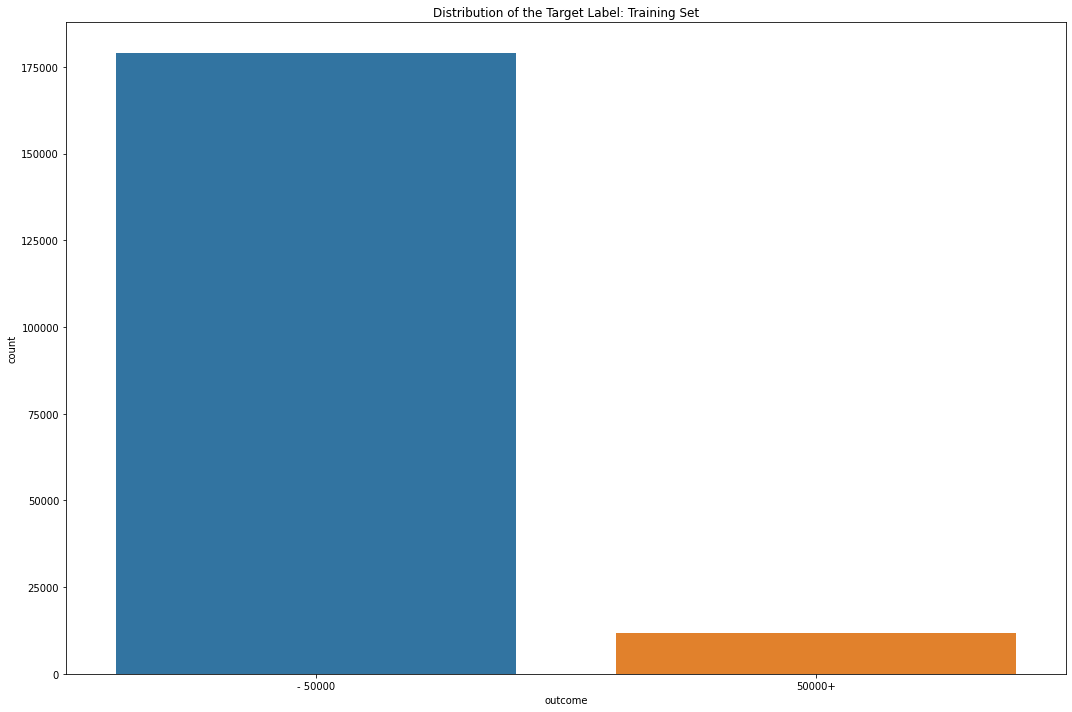

In [241]:
"""visualize the distribution of the target label in the training dataset"""

fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=census_income_train, x='outcome')
plt.title('Distribution of the Target Label: Training Set')
plt.tight_layout()

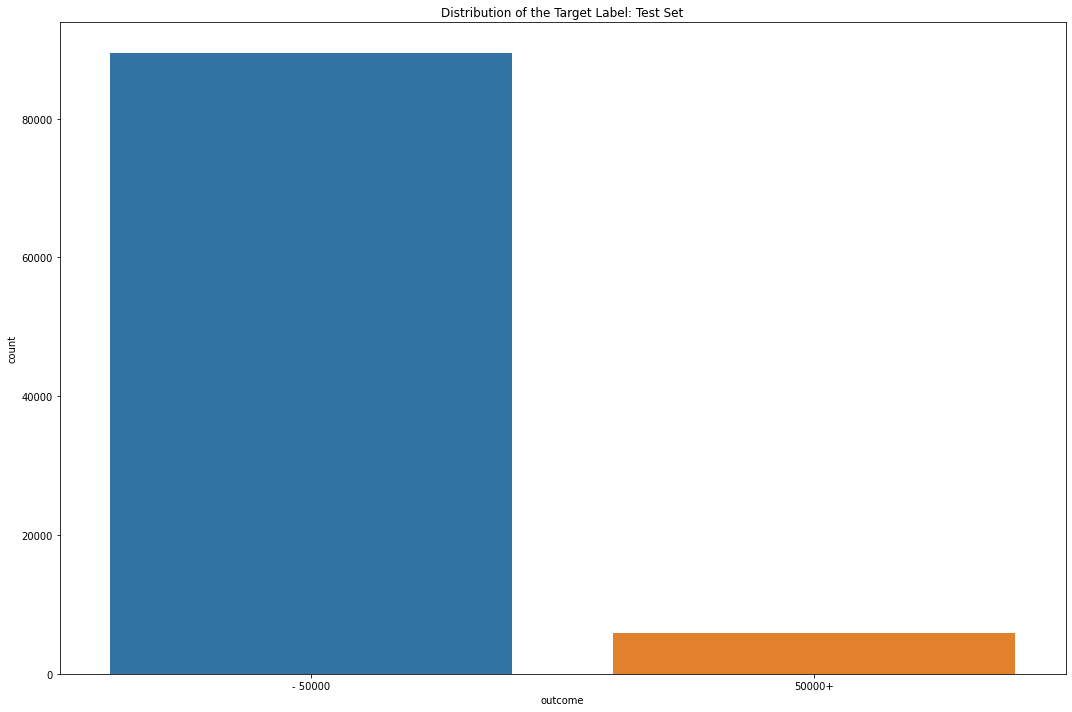

In [242]:
"""visualize the distribution of the target label in the training dataset"""

fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=census_income_test, x='outcome')
plt.title('Distribution of the Target Label: Test Set')
plt.tight_layout()

## *_Data Preprocessing_*

*Objectives*

- Apply robust scaler to numeric features
- Encode categorical features as integers one hot encoding
- Encode outcome as binary classifier (0/1)

In [243]:
"""apply preprocessing to the training and test set"""

#instantiate transformers
scaler = RobustScaler()
le = LabelEncoder()
oe = OrdinalEncoder()
#separate features and target
X_train = census_income_train.iloc[:, :-1]
y_train = census_income_train.iloc[:, -1:]
# apply transformers to training data
scaler.fit(X_train[continuous_features])
X_train[continuous_features] = scaler.transform(X_train[continuous_features])
nominal_features = X_train.select_dtypes(include=['category']).columns.tolist()
X_train[nominal_features] = oe.fit_transform(X_train[nominal_features])
y_train['outcome'] = le.fit_transform(y_train.to_numpy().flatten())
#separate features and target
X_test = census_income_test.iloc[:, :-1]
y_test = census_income_test.iloc[:, -1:]
# apply transformers to test data
scaler.transform(X_test[continuous_features])
X_test[nominal_features] = oe.fit_transform(X_test[nominal_features])
y_test['outcome'] = le.fit_transform(y_test.to_numpy().flatten())

In [244]:
le.classes_

array(['- 50000', '50000+'], dtype=object)

## *_Modeling_*

*Objectives*

- Apply the following modeling techniques to the data
    - Logistic Regression (base model)
    - Decision Tree Classification
    - Gradient Boosting Classifier
- Print the feature importances for each model

Logistic Regression

In [245]:
params = {'C': [0.5, 2.0, 5.0], 'class_weight': ['auto', 'balanced']}
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=2000, random_state=42), param_grid=params, cv=3)
lr_grid_search.fit(X_train, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the logistic regression model are:", lr_grid_search.best_params_)

/Users/benkarabinus/.local/share/virtualenvs/COMP4448-zVXvr8KM/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkarabinus/.local/share/virtualenvs/COMP4448-zVXvr8KM/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

The optimal hyperparameters for the logistic regression model are: {'C': 5.0, 'class_weight': 'auto'}


/Users/benkarabinus/.local/share/virtualenvs/COMP4448-zVXvr8KM/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [246]:
"""make predictions on the training and test sets"""

# make predictions on the training and test sets
y_train_pred = lr_grid_search.predict(X_train)
y_test_pred = lr_grid_search.predict(X_test)

In [247]:
"""print results of logistic regression applied to the training set"""

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    178904
           1       0.67      0.25      0.36     11657

    accuracy                           0.95    190561
   macro avg       0.81      0.62      0.67    190561
weighted avg       0.94      0.95      0.93    190561



In [248]:
"""print results of logistic regression applied to the test set"""

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.21      0.35     89409
           1       0.08      1.00      0.14      5809

    accuracy                           0.26     95218
   macro avg       0.54      0.61      0.24     95218
weighted avg       0.94      0.26      0.34     95218



Decision Tree Classifier

In [249]:
"""perform initial hyperparameter tuning for decision tree classifier"""

params = {'max_depth': range(1, 21), 'max_features': [0.1, 0.2, 0.3, 0.4], 'min_samples_split': [2, 4]}
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3)
dtc_grid_search.fit(X_train, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the decision tree classifier are:", dtc_grid_search.best_params_)

The optimal hyperparameters for the decision tree classifier are: {'max_depth': 10, 'max_features': 0.4, 'min_samples_split': 2}


In [250]:
"""make predictions on the training and test sets"""

# make predictions on the training and test sets
y_train_pred = dtc_grid_search.predict(X_train)
y_test_pred = dtc_grid_search.predict(X_test)

In [251]:
"""print results of the model applied to the training set"""

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    178904
           1       0.79      0.35      0.48     11657

    accuracy                           0.95    190561
   macro avg       0.87      0.67      0.73    190561
weighted avg       0.95      0.95      0.95    190561



In [252]:
"""print the results of the model applied to the test set"""

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     89409
           1       0.45      0.32      0.37      5809

    accuracy                           0.93     95218
   macro avg       0.70      0.65      0.67     95218
weighted avg       0.93      0.93      0.93     95218



Gradient Boosting Classifier

In [253]:
"""perform hyperparameter tuning for gradient boosting classifier"""

params = {'max_features': [1.0, 'sqrt', 'log2'], 'learning_rate': [0.001, 0.05, 0.10]}
gbc_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=params, cv=3)
gbc_grid_search.fit(X_train, y_train.to_numpy().flatten())
best_params = gbc_grid_search.best_params_
print("The optimal hyperparameters for the gradient boosting classifier are:", best_params)

The optimal hyperparameters for the gradient boosting classifier are: {'learning_rate': 0.1, 'max_features': 1.0}


In [254]:
"""print the results of the gradient boosting model applied to the training set"""

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    178904
           1       0.79      0.35      0.48     11657

    accuracy                           0.95    190561
   macro avg       0.87      0.67      0.73    190561
weighted avg       0.95      0.95      0.95    190561



In [255]:
"""print the results of the gradient boosting model applied to the test set"""

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     89409
           1       0.45      0.32      0.37      5809

    accuracy                           0.93     95218
   macro avg       0.70      0.65      0.67     95218
weighted avg       0.93      0.93      0.93     95218



Print the feature importance for each model

In [256]:
"""get the feature importance from the logistic regression model and store in sorted dataframe"""

# get coefficients form logistic regression model
lr_coeffs = np.append(lr_grid_search.best_estimator_.intercept_, lr_grid_search.best_estimator_.coef_)
# get feature names
feature_names = np.append('intercept', X_train.columns)
# create a data frame
results = pd.DataFrame(lr_coeffs, index=feature_names, columns=['coef'])
# re
results['odds'] = np.exp(lr_coeffs)
results.sort_values(by='odds', ascending=False, inplace=True)
results

,coef,odds
sex,1.400156,4.055832
num_persons_worked_for_employer,1.093026,2.983287
weeks_worked_in_year,1.081109,2.947947
age,0.574269,1.775833
family_members_under_18,0.463946,1.590337
veterans_benefits,0.183188,1.201041
year,0.159612,1.173055
citizenship,0.130497,1.139394
live_in_this_house_1_year_ago,0.089347,1.093460
class_of_worker,0.079049,1.082257


In [257]:
"""get the feature importance from the decision tree classifier and store in sorted dataframe"""

# get coefficients form logistic regression model
dtc_importance = dtc_grid_search.best_estimator_.feature_importances_
# get feature names
feature_names = X_train.columns.tolist()
# create a data frame
results = pd.DataFrame(dtc_importance, index=feature_names, columns=['feature_importance'])
# sort the dataframe
results.sort_values(by='feature_importance', ascending=False, inplace=True)
results

,feature_importance
capital_gains,0.303822
detailed_occupation_recode,0.262881
dividends_from_stocks,0.131282
sex,0.088491
capital_losses,0.051140
age,0.042706
num_persons_worked_for_employer,0.020671
weeks_worked_in_year,0.019523
detailed_household_and_family_stat,0.014080
detailed_industry_recode,0.009589


In [258]:
"""get the feature importance from the gradient boosting classifier and store in sorted dataframe"""

# get coefficients form logistic regression model
gbc_importance = gbc_grid_search.best_estimator_.feature_importances_
# get feature names
feature_names = X_train.columns.tolist()
# create a data frame
results = pd.DataFrame(gbc_importance, index=feature_names, columns=['feature_importance'])
# sort the dataframe
results.sort_values(by='feature_importance', ascending=False, inplace=True)
results

,feature_importance
capital_gains,0.248232
weeks_worked_in_year,0.142524
dividends_from_stocks,0.140341
detailed_occupation_recode,0.132199
sex,0.105320
capital_losses,0.059523
education,0.048340
age,0.038669
major_occupation_code,0.024559
num_persons_worked_for_employer,0.019839


## *_Apply Clustering Techniques to the Feature Set_*

Objectives

- Apply preprocessing steps to prepare the data for clustering.
- Apply Principal Components Analysis to the training and test sets. Specify two principal components for the dataset.
- Create a dendrogram to help determine the optimal number of clusters for the training data.
- Create an elbow plot to help determine the optimal number of clusters for the training data.
- Apply K-means clustering to the training data using optimal clusters determined by dendrogram and elbow plot
- Apply K-means clustering to the data using two clusters
    - Apply to both the training and test sets
- Examine frequency distribution of labels determined by K-means and compare to the ground truth in training and test sets

Apply preprocessing steps to prepare the data for clustering.

In [259]:
"""apply clustering preprocessing to the training and test set"""

#instantiate transformers
scaler = MinMaxScaler()
#separate features and target
X_train_cluster = census_income_train.iloc[:, :-1]
y_train_cluster = census_income_train.iloc[:, -1:]
X_test_cluster = census_income_test.iloc[:, :-1]
y_test_cluster = census_income_test.iloc[:, -1:]
# apply transformers to training data
scaler.fit(X_train_cluster[continuous_features])
X_train_cluster[continuous_features] = scaler.transform(X_train_cluster[continuous_features])
X_train_cluster = pd.get_dummies(X_train_cluster)
scaler.fit(X_test_cluster[continuous_features])
X_test_cluster[continuous_features] = scaler.transform(X_test_cluster[continuous_features])
X_test_cluster = pd.get_dummies(X_test_cluster)

Apply Principal Components Analysis to the training and test sets. Specify two principal components for the dataset.

In [260]:
"""reduce the training to two principal components"""

# instantiate and fit PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_cluster)
X_train_pca = pd.DataFrame(data=X_train_pca, columns=['principal_component_1', 'principal_component_2'])
X_train_pca['outcome'] = y_train_cluster.to_numpy()
X_train_pca.head()

,principal_component_1,principal_component_2,outcome
0,0.772663,1.367002,- 50000
1,-1.237110,-1.065646,- 50000
2,1.053875,1.430102,- 50000
3,2.629036,-0.929851,- 50000
4,2.628215,-0.929783,- 50000


In [261]:
"""reduce the test to two principal components"""

# instantiate and fit PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_cluster)
X_test_pca = pd.DataFrame(data=X_test_pca, columns=['principal_component_1', 'principal_component_2'])
X_test_pca['outcome'] = y_test_cluster.to_numpy()
X_test_pca.head()

,principal_component_1,principal_component_2,outcome
0,-1.514301,1.141869,- 50000
1,-1.396217,0.900735,- 50000
2,2.579155,0.827486,- 50000
3,-1.568661,-1.268827,- 50000
4,-1.605236,1.064054,- 50000


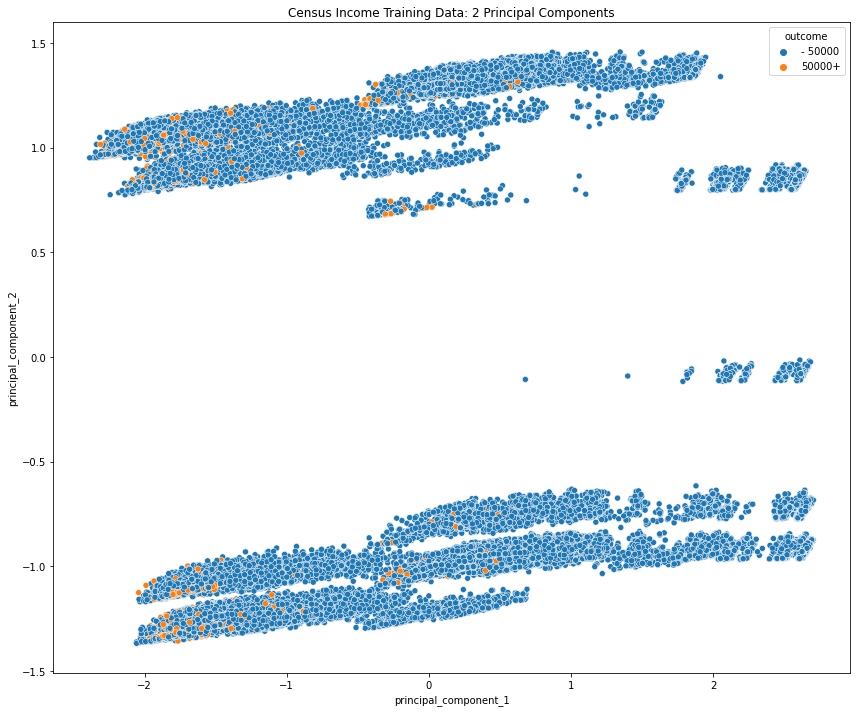

In [262]:
"""visualize the two principal components, taining data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=X_train_pca, x='principal_component_1', y='principal_component_2', hue='outcome')
plt.title('Census Income Training Data: 2 Principal Components')
plt.tight_layout()
plt.show()

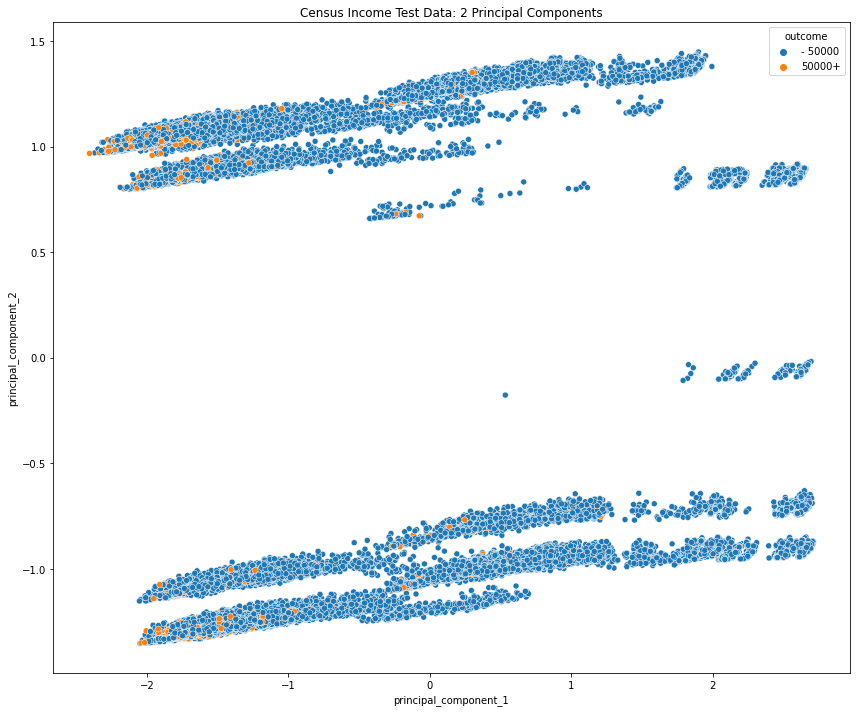

In [263]:
"""visualize the two principal components, test data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=X_test_pca, x='principal_component_1', y='principal_component_2', hue='outcome')
plt.title('Census Income Test Data: 2 Principal Components')
plt.tight_layout()
plt.show()

Create a dendrogram to help determine the optimal number of clusters.

In [264]:
"""apply agglomerative hierarchical clustering to the data to get inputs for dendrogram"""

# set random seed for repeatability
random.seed(42)
# create an agglomerative clustering model using random sample, size=10% of records
cluster_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
cluster_model.fit(X_train_pca.iloc[:, :-1].sample(frac=.15))

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [265]:
"""create a function to plot the dendrogram of the clustering matrix (sample code provided by sklearn)"""

def plot_dendrogram(model, **kwargs):

    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(cluster_model.children_.shape[0])
    n_samples = len(cluster_model.labels_)
    for i, merge in enumerate(cluster_model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    plt.xlabel("Number of points in each node.")

    # Plot the dendrogram using the linkage matrix
    ch.dendrogram(linkage_matrix, **kwargs)

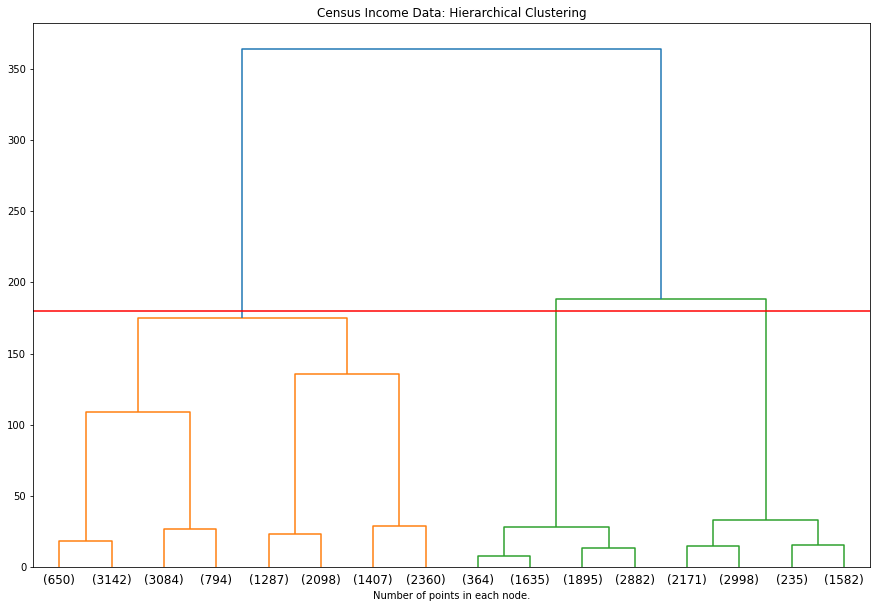

In [266]:
"""plot the dendrogram of the hiearchical clustering model"""

fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Census Income Data: Hierarchical Clustering')
plot_dendrogram(cluster_model, truncate_mode='level', p=3)
plt.axhline(y=180, color='r', linestyle='-')
plt.show()

Create an elbow plot to help determine the optimal number of clusters

In [267]:
"""calculate within cluster sum of squares for elbow plot"""

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=42, n_init=10)
    kmeans.fit(X_train_pca.iloc[:, :-1])
    wcss.append(kmeans.inertia_)

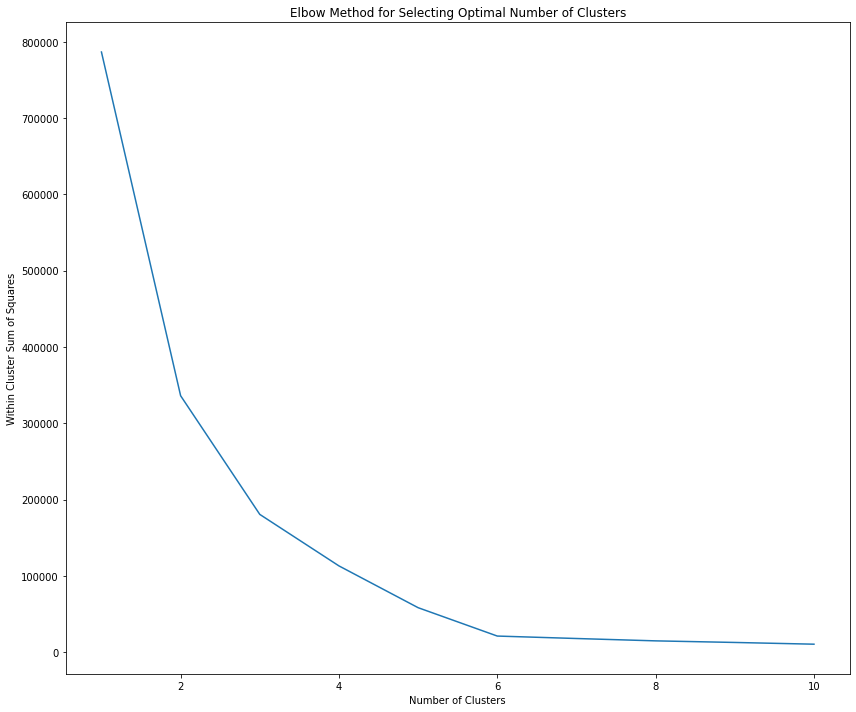

In [268]:
# create the elbow plot
clusters = [i for i in range(1, 11)]
wcss = wcss
fig, ax = plt.subplots(figsize=(12, 10))
plt.plot(clusters, wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Method for Selecting Optimal Number of Clusters')
plt.tight_layout()
plt.show()

Apply K-means clustering to the  training data using optimal clusters determined by dendrogram and elbow plot

In [269]:
"""define a helper function to visualize K-means results"""

def plot_kmeans(model, data, predictions):
    # instantiate the pyplot objects
    fig, ax = plt.subplots(figsize=(12, 10))
    # get unique labels in predictions
    labels = np.unique(predictions)
    # get centroids form the fit model
    centroids = model.cluster_centers_
    # iterate over predicted labels and create scatter plot for each
    for label in labels:
        filtered = data[data['kmeans_results'] == label]
        plt.scatter(filtered.iloc[:, :1], filtered.iloc[:, 1:2])
    # add centroids to the graph
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black')
    # add legend for label values
    plt.legend(labels)
    # add title
    title = 'K-means Results {} Centroids'.format(len(labels))
    plt.title(title)
    plt.tight_layout()
    plt.show()

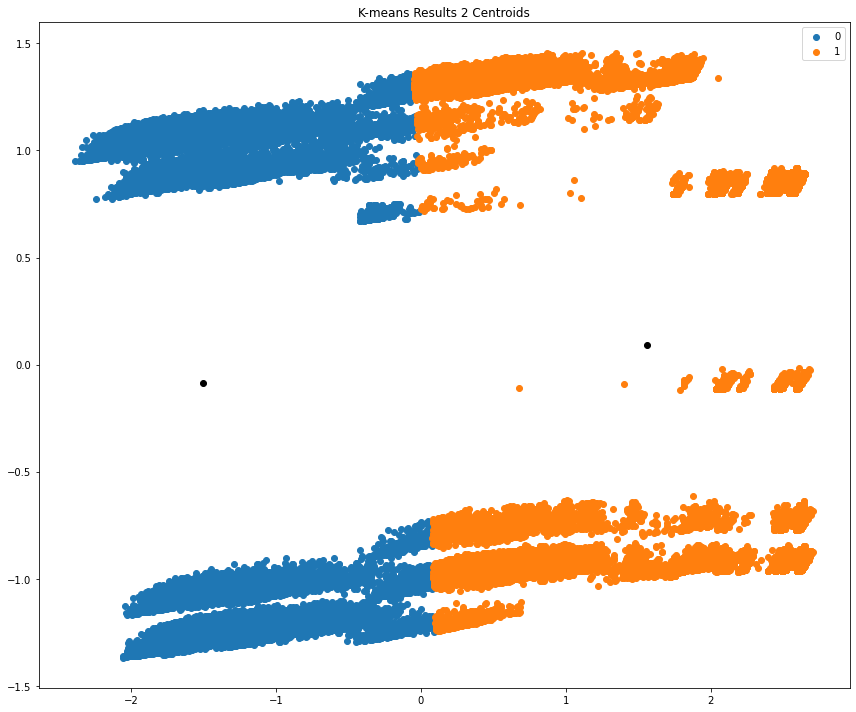

In [270]:
"""implement K-means on the training set then visualize results"""

# instantiate model
kmeans = KMeans(n_clusters=2, init = 'k-means++', random_state=42)
# make predictions and append to dataframe
y_kmeans = kmeans.fit_predict(X_train_pca.iloc[:, :-1])
X_train_pca['kmeans_results'] = y_kmeans
#plot results
plot_kmeans(kmeans, X_train_pca, y_kmeans)

Apply K-means clustering to the data using two clusters.
- Apply to both the training and test sets

In [271]:
"""drop prior results from the training and test sets"""

X_train_pca.drop(columns=['kmeans_results'], inplace=True)

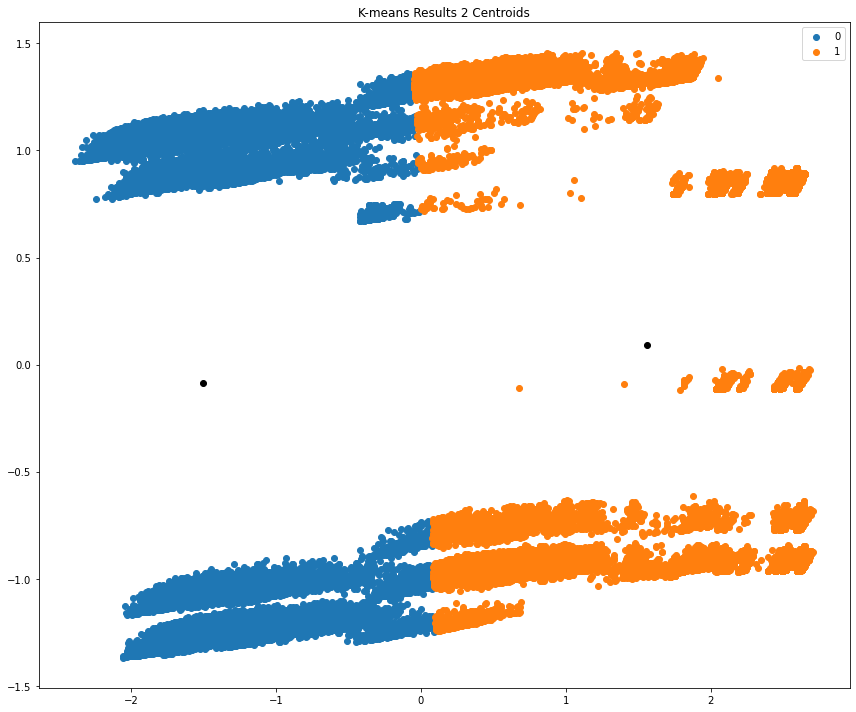

In [272]:
"""implement K-means on the training set using 2 centroids then visulaize results"""

kmeans_train = KMeans(n_clusters=2, init = 'k-means++', random_state=42)
y_kmeans_train = kmeans_train.fit_predict(X_train_pca.iloc[:, :-1])
X_train_pca['kmeans_results'] = y_kmeans_train
plot_kmeans(kmeans_train, X_train_pca, y_kmeans_train)

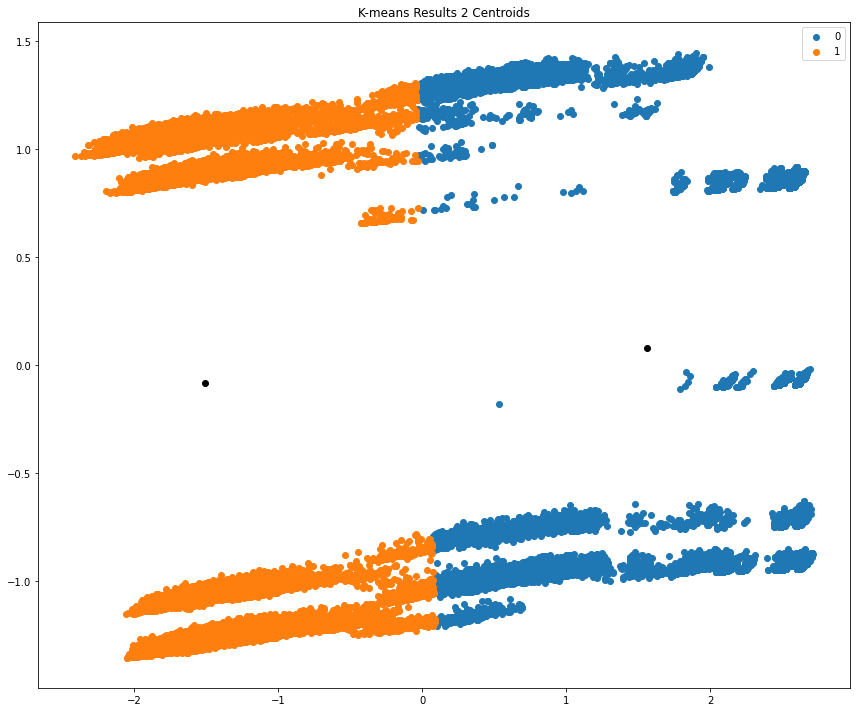

In [273]:
"""implement K-means on the test set using 2 centroids then visulaize results"""

kmeans_test = KMeans(n_clusters=2, init = 'k-means++', random_state=42)
y_kmeans_test = kmeans_test.fit_predict(X_test_pca.iloc[:, :-1])
X_test_pca['kmeans_results'] = y_kmeans_test
plot_kmeans(kmeans_test, X_test_pca, y_kmeans_test)

Examine frequency distribution of labels determined by K-means and compare to the ground truth in training and test sets.

In [274]:
"""print class frequency distribution in the training set"""

census_income_train.iloc[:, -1:].value_counts(normalize=True)

outcome
- 50000    0.938828
50000+     0.061172
dtype: float64

In [275]:
"""print class frequency distribution in the kmeans results, training set"""

X_train_pca.iloc[:, -1:].value_counts(normalize=True)

kmeans_results
0                 0.508583
1                 0.491417
dtype: float64

In [276]:
"""print class frequency distribution in the test set"""

census_income_test.iloc[:, -1:].value_counts(normalize=True)

outcome
- 50000    0.938993
50000+     0.061007
dtype: float64

In [199]:
"""print class frequency distribution in the kmeans results, test set"""

X_test_pca.iloc[:, -1:].value_counts(normalize=True)

kmeans_results
1                 0.508129
0                 0.491871
dtype: float64